# Setting Up Environment

In [1]:
import math, os, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, AlphaDropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping

tqdm.pandas()
tf.random.set_seed(42)

%matplotlib inline

print(tf.__version__)

2.4.1


# Data Preparation

In [2]:
raw_data = pd.read_csv('../input/bt4222-project/modelling_dataset.csv')
raw_data = pd.concat([raw_data.pop('Unit Price ($ PSM)'), raw_data], axis=1)

raw_data

,Unit Price ($ PSM),Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
0,6316.0,95.0,1.0,124.3,33,705.752731,1207.822015,87.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13833.0,138.0,1.0,124.3,58,1233.947139,768.529003,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,8990.0,99.0,10.0,124.3,50,1039.586179,816.818037,80.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,6306.0,111.0,6.0,124.3,33,509.516515,501.364218,80.0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,13934.0,122.0,10.0,124.3,58,1253.733260,554.491114,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54669,8229.0,192.0,4.0,153.3,66,526.868822,464.021930,76.0,0,0,...,0,0,0,0,1,0,0,0,0,0
54670,7838.0,111.0,14.0,153.3,66,535.286185,490.669867,80.0,0,0,...,0,0,0,0,1,1,0,0,0,1
54671,13028.0,142.0,14.0,153.3,133,2075.609094,600.145285,72.0,0,0,...,0,0,0,0,0,0,0,1,0,0
54672,13931.0,58.0,6.0,153.3,51,397.651025,539.116552,91.0,0,0,...,0,1,0,0,0,0,0,0,0,0


# Train-Test Split

In [3]:
# Perform 70/30 train_test split
X = raw_data.iloc[:,1:].copy()
y = raw_data.iloc[:,0:1].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
11187,129.0,9.0,139.2,66,313.319878,1514.605671,85.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18593,66.0,13.0,142.3,63,408.305136,1517.388799,84.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27013,61.0,58.0,137.7,85,1529.338980,148.651892,86.0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
39116,105.0,18.0,141.6,66,270.671774,225.750354,86.0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6042,111.0,37.0,132.6,60,339.216214,258.201238,87.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,107.0,3.0,145.2,36,102.333066,622.895879,73.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
54343,66.0,2.0,153.3,64,414.799433,805.354104,87.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
38158,74.0,3.0,141.6,142,774.750823,466.130105,76.0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
860,91.0,14.0,124.3,133,658.187930,310.779399,83.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# Feature Scaling

In [4]:
def all_transform(X_train, X_test):
    all_features = list(X_train.columns)

    standardScale_vars = ['Area (SQM)',
                          'Floor Number',
                          'PPI',
                          'Average Cases Per Year',
                          'Nearest Primary School',
                          'nearest_station_distance']

    minMax_vars = ['Remaining Lease']

    remaining_features = [x for x in all_features if x not in standardScale_vars and x not in minMax_vars]

    s_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()

    s_scaled = pd.DataFrame(s_scaler.fit_transform(X_train.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_train.index)
    mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_train.index)

    X_train = pd.concat([s_scaled, 
                         mm_scaled, 
                         X_train.loc[:, remaining_features].copy()], axis=1)

    s_scaled = pd.DataFrame(s_scaler.transform(X_test.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_test.index)
    mm_scaled = pd.DataFrame(mm_scaler.transform(X_test.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_test.index)

    X_test = pd.concat([s_scaled, 
                        mm_scaled, 
                        X_test.loc[:, remaining_features].copy()], axis=1)
    
    return X_train, X_test

In [5]:
X_train, X_test = all_transform(X_train, X_test)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
11187,0.291530,-0.109176,-0.236229,0.243812,-0.771624,1.226898,0.745098,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18593,-1.125873,0.371998,0.210453,0.125051,-0.570640,1.231468,0.725490,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27013,-1.238366,5.785202,-0.452365,0.995966,1.801408,-1.015899,0.764706,0,0,0,...,0,1,0,1,0,0,1,1,1,0
39116,-0.248433,0.973465,0.109589,0.243812,-0.861865,-0.889309,0.764706,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6042,-0.113442,3.259040,-1.187229,0.006290,-0.716828,-0.836027,0.784314,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,-0.203436,-0.830937,0.628316,-0.943799,-1.218061,-0.237225,0.509804,1,0,0,...,0,0,0,0,0,0,1,0,0,0
54343,-1.125873,-0.951230,1.795452,0.164638,-0.556898,0.062359,0.784314,0,0,0,...,0,0,1,0,0,0,1,0,0,0
38158,-0.945886,-0.830937,0.109589,3.252428,0.204740,-0.494623,0.568627,0,0,0,...,0,1,0,0,0,1,0,0,0,0
860,-0.563412,0.492291,-2.383183,2.896144,-0.041901,-0.749697,0.705882,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# Train-Validation Split

In [6]:
# Train-Validation Split
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
9079,-0.338427,-0.830937,-0.510002,-0.072884,-0.337170,-0.184168,0.843137,0,0,0,...,0,0,0,0,0,1,0,1,0,0
50500,0.426521,-0.349763,1.147043,2.896144,-0.084831,-0.944134,0.568627,0,0,0,...,0,0,0,1,0,0,0,1,1,0
42324,-0.068445,1.334345,0.757998,-1.022973,-0.477199,-0.716844,0.882353,0,0,1,...,0,0,0,0,0,0,1,1,0,0
33190,2.496380,0.612585,-1.028729,0.006290,0.510938,0.544301,0.862745,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12391,-0.023448,-0.590350,-0.005684,-0.864625,-0.737739,0.647023,0.803922,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40185,-0.225935,0.371998,0.757998,0.243812,-0.729890,0.154151,0.862745,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46425,0.336527,0.612585,1.319952,0.243812,0.209585,-0.999626,0.725490,0,0,0,...,0,0,0,0,0,1,0,0,0,0
33159,-0.068445,-0.951230,-1.028729,-0.943799,-1.148569,-0.292310,0.549020,1,0,0,...,0,0,0,0,0,0,1,0,0,0
46563,-0.810895,0.492291,1.319952,-0.825038,0.254966,-0.725711,0.882353,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)
print(X_test.shape)
print(y_test.shape)

(30616, 52)
(30616, 1)
(7655, 52)
(7655, 1)
(16403, 52)
(16403, 1)


# Baseline Model (Unregularized)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               6784      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

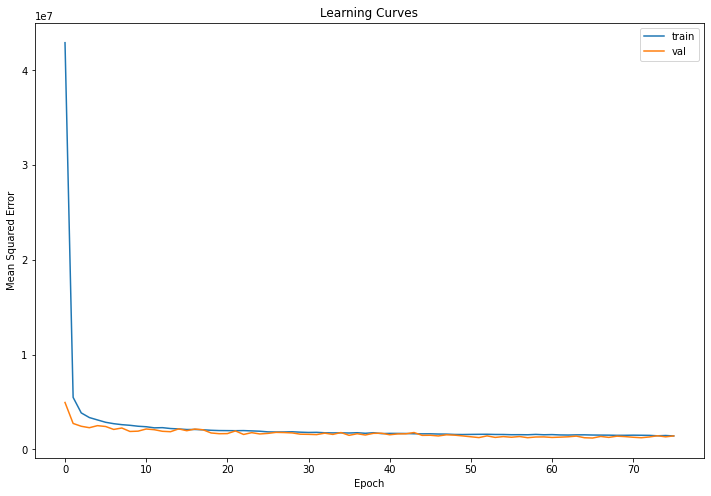

Train RMSE: 1063.715, Train MAPE: 5.694 

Val RMSE: 1098.133, Val MAPE: 6.074 

Test RMSE: 1132.732, Test MAPE: 6.173 

CPU times: user 5min 31s, sys: 40.8 s, total: 6min 12s
Wall time: 2min 54s


<Figure size 864x576 with 0 Axes>

In [8]:
%%time

# Model Hyperparameters
nodes = [128, 256, 512]
batch_norm = (True, True)
drop_rate = 0.5

# Model building
n_features = X_train.shape[1]

model = Sequential()
model.add(Dense(nodes[0], activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))

if batch_norm[0]:
    model.add(BatchNormalization())
else:
    model.add(Dropout(drop_rate))

model.add(Dense(nodes[1], activation='relu', kernel_initializer='he_normal'))

if batch_norm[1]:
    model.add(BatchNormalization())
else:
    model.add(Dropout(drop_rate))

model.add(Dense(nodes[2], activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(drop_rate))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
print(model.summary(), '\n')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Model Errors
plt.rcParams['figure.figsize'] = 12,8

plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.show()
plt.clf()

# Model Evaluation
y_train_pred = model.predict(X_train)
y_eval_pred = model.predict(X_eval)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(MeanSquaredError()(y_train, y_train_pred).numpy())
train_mape = MeanAbsolutePercentageError()(y_train, y_train_pred).numpy()

eval_rmse = np.sqrt(MeanSquaredError()(y_eval, y_eval_pred).numpy())
eval_mape = MeanAbsolutePercentageError()(y_eval, y_eval_pred).numpy()

test_rmse = np.sqrt(MeanSquaredError()(y_test, y_test_pred).numpy())
test_mape = MeanAbsolutePercentageError()(y_test, y_test_pred).numpy()

print('Train RMSE: %.3f, Train MAPE: %.3f' % (train_rmse, train_mape), '\n')
print('Val RMSE: %.3f, Val MAPE: %.3f' % (eval_rmse, eval_mape), '\n')
print('Test RMSE: %.3f, Test MAPE: %.3f' % (test_rmse, test_mape), '\n')

# Model Hyperparameter Tuning (Regularization Type + Lambda)

In [9]:
def model_tuning_3nn(reg_type='L2', lambda_val=0.01):

    # Model Hyperparameters
    nodes = [128, 256, 512]
    batch_norm = (True, True)
    drop_rate = 0.5
    
    # Model building
    n_features = X_train.shape[1]
    
    # Selecting regularization type
    if reg_type == 'L1':
        regularizer = tf.keras.regularizers.L1(l1=lambda_val)
    
    elif reg_type == 'L2':
        regularizer = tf.keras.regularizers.L2(l2=lambda_val)

    model = Sequential()
    model.add(Dense(nodes[0], activation='relu', kernel_initializer='he_normal', input_shape=(n_features,), kernel_regularizer=regularizer))

    if batch_norm[0]:
        model.add(BatchNormalization())
    else:
        model.add(Dropout(drop_rate))

    model.add(Dense(nodes[1], activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizer))

    if batch_norm[1]:
        model.add(BatchNormalization())
    else:
        model.add(Dropout(drop_rate))

    model.add(Dense(nodes[2], activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizer))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    print(model.summary(), '\n')

    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])

    # Model Errors
    plt.rcParams['figure.figsize'] = 12,8

    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()

    plt.show()
    plt.clf()

    # Model Evaluation
    y_train_pred = model.predict(X_train)
    y_eval_pred = model.predict(X_eval)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(MeanSquaredError()(y_train, y_train_pred).numpy())
    train_mape = MeanAbsolutePercentageError()(y_train, y_train_pred).numpy()
    
    eval_rmse = np.sqrt(MeanSquaredError()(y_eval, y_eval_pred).numpy())
    eval_mape = MeanAbsolutePercentageError()(y_eval, y_eval_pred).numpy()

    test_rmse = np.sqrt(MeanSquaredError()(y_test, y_test_pred).numpy())
    test_mape = MeanAbsolutePercentageError()(y_test, y_test_pred).numpy()

    print('Train RMSE: %.3f, Train MAPE: %.3f' % (train_rmse, train_mape), '\n')
    print('Val RMSE: %.3f, Val MAPE: %.3f' % (eval_rmse, eval_mape), '\n')
    print('Test RMSE: %.3f, Test MAPE: %.3f' % (test_rmse, test_mape), '\n')
    
    return pd.DataFrame([{'regularizer': reg_type,
                         'lambda': lambda_val,
                         'train_rmse': train_rmse,
                         'validation_rmse': eval_rmse,
                         'test_rmse': test_rmse,
                         'train_mape': train_mape,
                         'validation_mape': eval_mape,
                         'test_mape': test_mape}])

# Collecting Error Metrics (for comparison)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               6784      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

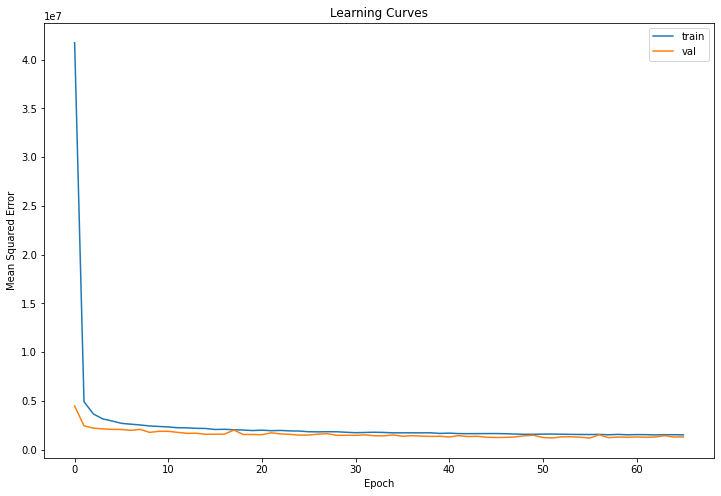

Train RMSE: 1036.159, Train MAPE: 5.834 

Val RMSE: 1077.567, Val MAPE: 6.161 

Test RMSE: 1147.074, Test MAPE: 6.258 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               6784      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         


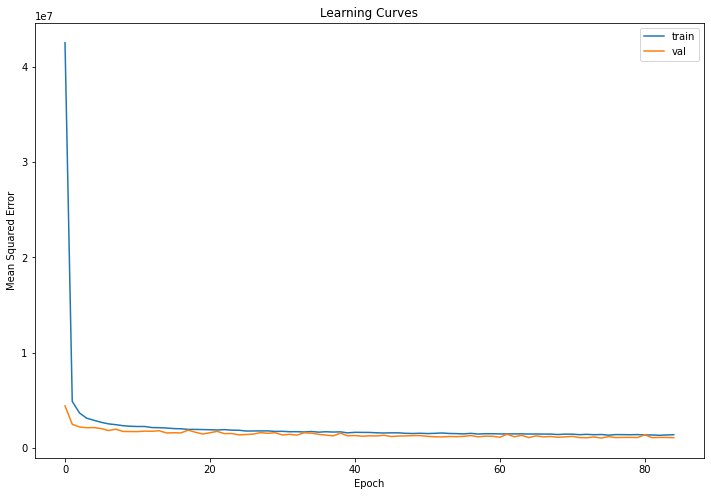

Train RMSE: 918.447, Train MAPE: 5.265 

Val RMSE: 998.254, Val MAPE: 5.703 

Test RMSE: 1026.549, Test MAPE: 5.726 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
__

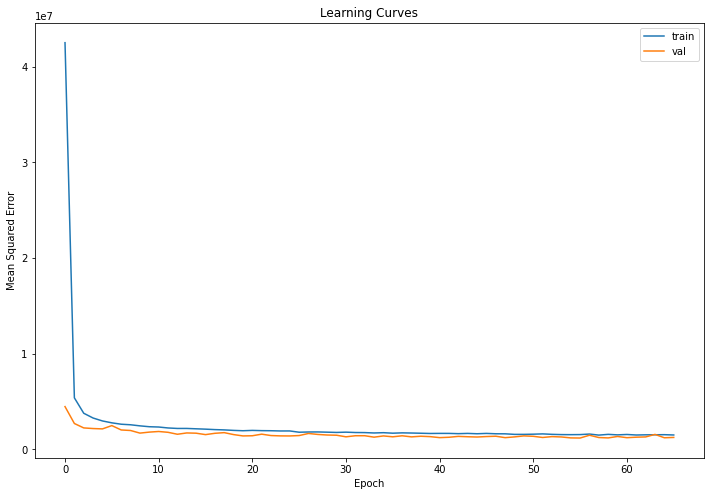

Train RMSE: 1014.536, Train MAPE: 5.857 

Val RMSE: 1068.626, Val MAPE: 6.174 

Test RMSE: 1119.323, Test MAPE: 6.277 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_18 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         


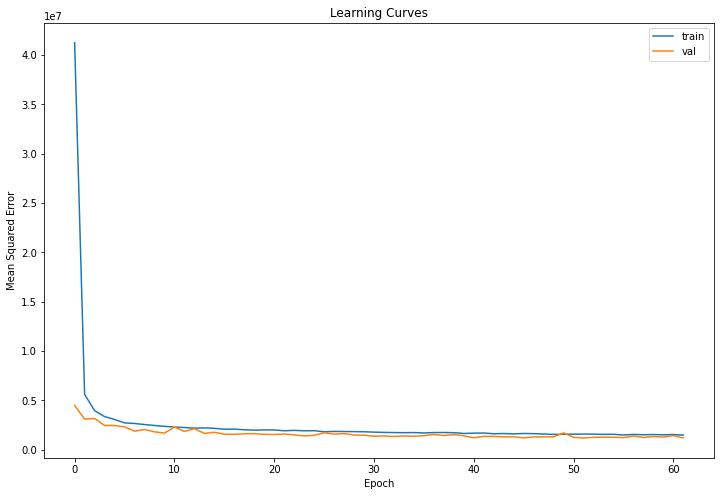

Train RMSE: 974.633, Train MAPE: 5.761 

Val RMSE: 1045.937, Val MAPE: 6.116 

Test RMSE: 1063.124, Test MAPE: 6.167 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_

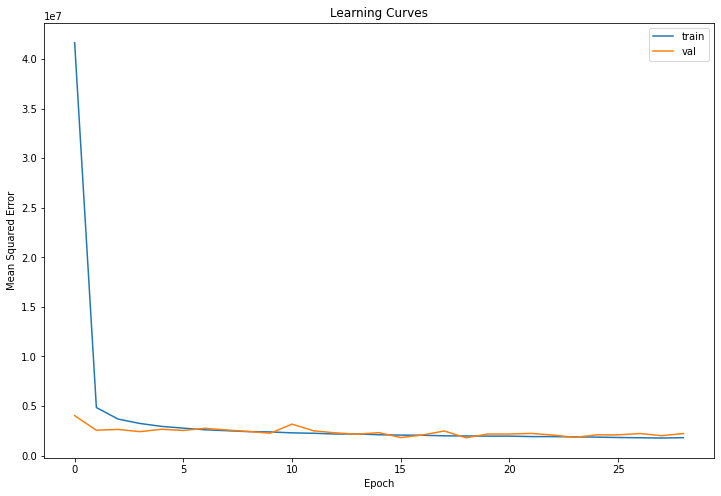

Train RMSE: 1411.248, Train MAPE: 6.825 

Val RMSE: 1452.415, Val MAPE: 7.104 

Test RMSE: 1424.965, Test MAPE: 7.174 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         


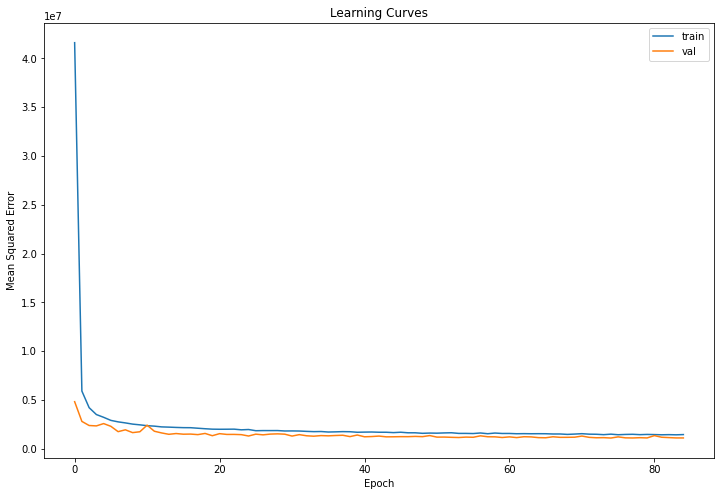

Train RMSE: 942.424, Train MAPE: 5.459 

Val RMSE: 1021.735, Val MAPE: 5.835 

Test RMSE: 1048.548, Test MAPE: 5.937 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_14 (Batc (None, 128)               512       
_________________________________________________________________
dense_29 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dense_30 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_

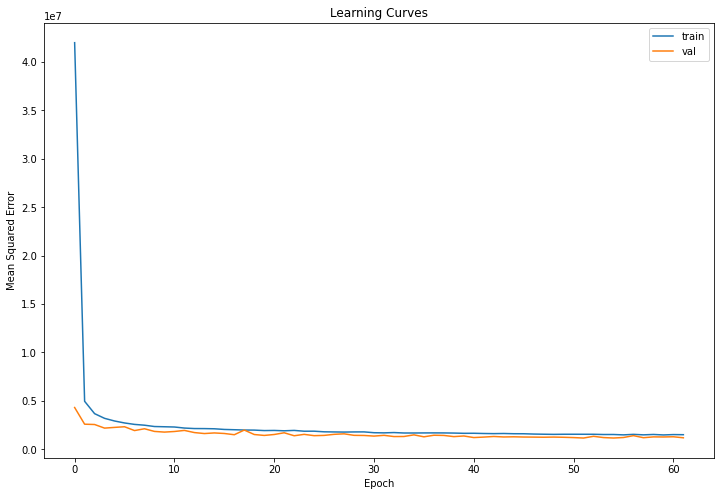

Train RMSE: 1006.242, Train MAPE: 5.763 

Val RMSE: 1057.077, Val MAPE: 6.078 

Test RMSE: 1090.973, Test MAPE: 6.183 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_16 (Batc (None, 128)               512       
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_34 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         


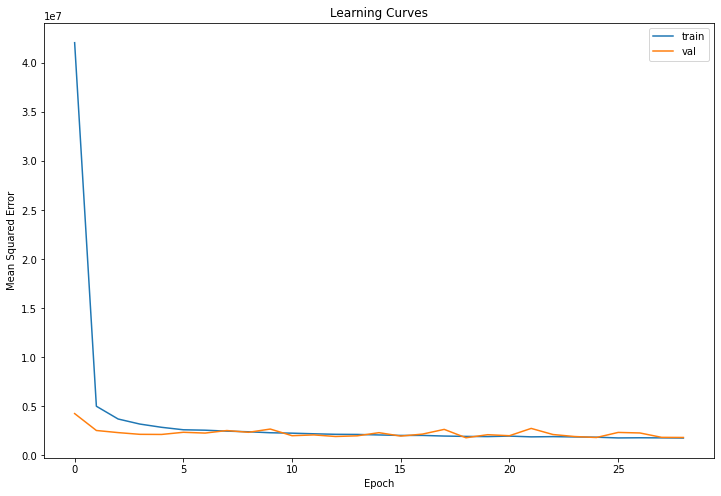

Train RMSE: 1302.350, Train MAPE: 6.891 

Val RMSE: 1346.340, Val MAPE: 7.126 

Test RMSE: 1343.469, Test MAPE: 7.209 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_18 (Batc (None, 128)               512       
_________________________________________________________________
dense_37 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
dense_38 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         


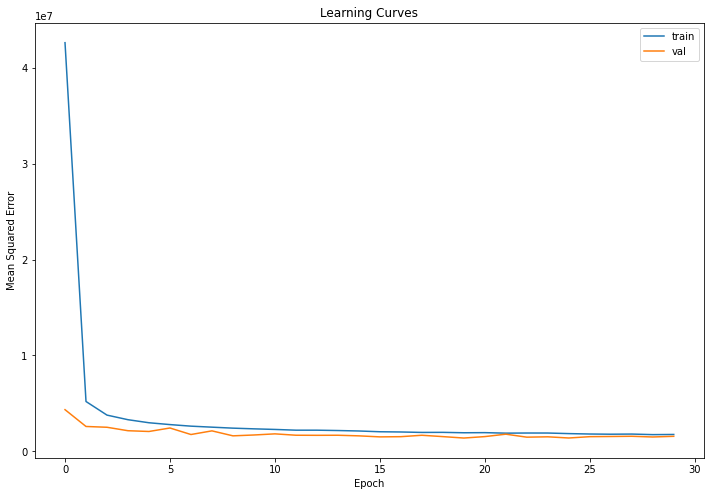

Train RMSE: 1157.465, Train MAPE: 6.254 

Val RMSE: 1212.066, Val MAPE: 6.511 

Test RMSE: 1217.697, Test MAPE: 6.618 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 128)               6784      
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_41 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
dense_42 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         

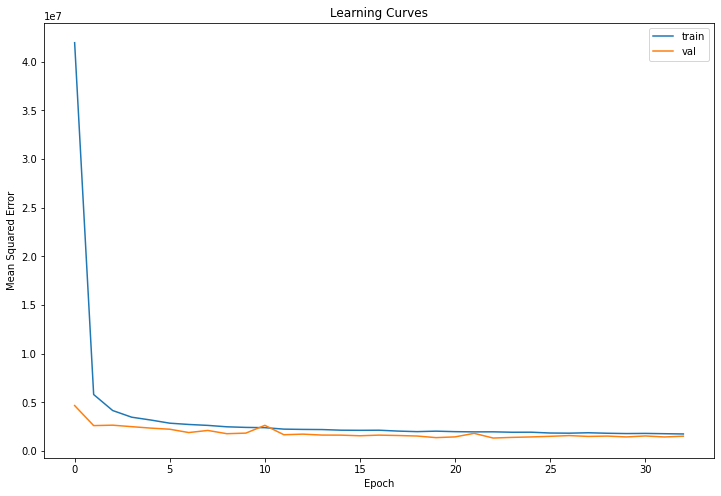

Train RMSE: 1157.290, Train MAPE: 6.220 

Val RMSE: 1210.465, Val MAPE: 6.496 

Test RMSE: 1258.091, Test MAPE: 6.664 



,regularizer,lambda,train_rmse,validation_rmse,test_rmse,train_mape,validation_mape,test_mape
0,L1,0.001,1036.159058,1077.567139,1147.073730,5.833584,6.160929,6.257632
1,L1,0.005,918.447327,998.253540,1026.548706,5.265132,5.703336,5.726269
2,L1,0.010,1014.535583,1068.626221,1119.322754,5.857394,6.173589,6.277034
3,L1,0.050,974.632874,1045.937378,1063.123779,5.761132,6.115815,6.166939
4,L1,0.100,1411.247559,1452.415161,1424.965088,6.824782,7.104136,7.174171
5,L2,0.001,942.424316,1021.734741,1048.547729,5.459197,5.835229,5.937350
6,L2,0.005,1006.242126,1057.077026,1090.972900,5.762632,6.077517,6.182529
7,L2,0.010,1302.349854,1346.339966,1343.469360,6.890778,7.125757,7.208656
8,L2,0.050,1157.464722,1212.065552,1217.697144,6.254179,6.511327,6.617653
9,L2,0.100,1157.290405,1210.464966,1258.090820,6.220200,6.496129,6.663588


<Figure size 864x576 with 0 Axes>

In [10]:
df_results = pd.DataFrame()

for reg in ['L1', 'L2']:
    for lam_val in [0.001, 0.005, 0.01, 0.05, 0.1]:
        output = model_tuning_3nn(reg_type=reg, lambda_val=lam_val)
        df_results = pd.concat([df_results, output], axis=0)
        
df_results.reset_index(drop=True, inplace=True)

df_results

# Saving Results

In [11]:
df_results.to_csv('3nn_regularized.csv', index=False)